In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [25]:
# Neural network for Forecasting data
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,    #0.05               best with 0.001
  decay_steps=100, #100        best with 100
  decay_rate=1, #1              best with 1
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

def get_callbacks(name):
    return [
        tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=50, min_delta=0.001),
        ]

def compile_and_fit(model, name, x_train, y_train, x_test, y_test, optimizer=None, max_epochs=100):

    if optimizer is None:
        optimizer = get_optimizer()

    model.compile(optimizer=optimizer,
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=[
                  tf.keras.losses.MeanAbsoluteError("auto", "mean_absolute_error"),
                  'accuracy'])

    model.summary()

    history = model.fit(
            x_train, y_train,
            epochs=max_epochs,
            validation_data=(x_test, y_test),
            callbacks=get_callbacks(name),
            verbose=2)

    return history

In [26]:
#Training data set
folder = 'Function' # 'Function' or 'Burgers'

input_train=np.load('../data/' + folder + '/input_train.npy')
input_test=np.load('../data/' + folder + '/input_test.npy')
output_train=np.load('../data/' + folder + '/output_train.npy')
output_test=np.load('../data/' + folder + '/output_test.npy')

INPUTDIM = (input_train.shape[1],)
OUTPUTDIM = (output_train.shape[1],)

In [27]:
# def Fourier_layer(input_layer):
#     fft =  layers.Lambda(fft_function) (input_layer)

#     w = layers.Dense(fft.get_shape().as_list()[1], kernel_regularizer = regularizers.l2(0.0)) (fft)

#     ifft = layers.Lambda(ifft_function) (tf.dtypes.complex(w,tf.multiply(w,tf.zeros_like(w))))

#     bias = layers.Dense(ifft.get_shape().as_list()[1], kernel_regularizer = regularizers.l2(0.0)) (input_layer)

#     print(ifft.shape)
#     print(bias.shape)

#     return layers.Add() ([ifft, bias])

# -----------------------------------------------------------
# Cal method of FFT_Layer (old versrion)
# def call(self, inputs):
#         fft =  layers.Lambda(self.fft_function) (inputs)
#         if self.fft_shape == None:
#             self._fft_shape = fft.get_shape().as_list()[1]
#             print('fft_shape set: ' + str(self._fft_shape))
#         w = layers.Dense(self.fft_shape, kernel_regularizer = regularizers.l2(0.0)) (fft)
#         ifft = layers.Lambda(self.ifft_function) (tf.dtypes.complex(w,tf.multiply(w,tf.zeros_like(w))))
#         if self.ifft_shape == None:
#             self._ifft_shape = ifft.get_shape().as_list()[1]
#             print('ifft_shape set: ' + str(self._ifft_shape))
#         return ifft

In [28]:
# class FFT_Layer(tf.keras.layers.Layer):
    
#     def __init__(self, **kwargs):
#         super(FFT_Layer, self).__init__(**kwargs)
#         self._fft_shape = None
#         self._ifft_shape = None

#     def build(self, input_shape):
#         self._fft_shape = np.int32(input_shape[-1]/2)+1
#         self._ifft_shape = np.int32(input_shape[-1]/2)*2
#         print('fft_shape set: ' + str(self._fft_shape))
#         print('ifft_shape set: ' + str(self._ifft_shape))
#         self.kernel = self.add_weight(
#             name="kernel",
#             shape=(input_shape[-1], self._fft_shape),
#             initializer="zeros",
#             trainable=True
#         )

#     def call(self, inputs):
#         fft =  layers.Lambda(self.fft_function) (inputs)
#         w = layers.Dense(self.fft_shape, kernel_regularizer = regularizers.l2(0.0)) (fft)
#         w.kernel = self.kernel
#         ifft = layers.Lambda(self.ifft_function) (tf.dtypes.complex(w,tf.multiply(w,tf.zeros_like(w))))
#         return ifft
    
#     def fft_function(self, tensor):
#         return tf.signal.rfft(tensor)

#     def ifft_function(self, tensor):
#         return tf.signal.irfft(tensor)
    
#     @property
#     def fft_shape(self):
#         return self._fft_shape
    
#     @property
#     def ifft_shape(self):
#         return self._ifft_shape
    
#     @fft_shape.setter
#     def fft_shape(self, value):
#         self._fft_shape = value
#         print('New fft_shape set: ' + str(self._fft_shape))

#     @ifft_shape.setter
#     def ifft_shape(self, value):
#         self._ifft_shape = value
#         print('New ifft_shape set: ' + str(self._ifft_shape))

    
# class Bias_Layer(tf.keras.layers.Layer):

#     def __init__(self, fft_layer_object, **kwargs):
#         super(Bias_Layer, self).__init__(**kwargs)
#         self.fft_layer_object = fft_layer_object

#     def build(self, input_shape):
#         # Create a trainable weight variable for the custom dense layer
#         self.kernel = self.add_weight(
#             name="kernel",
#             shape=(input_shape[-1], self.fft_layer_object.ifft_shape),
#             initializer="zeros",
#             trainable=True
#         )
        
#     def call(self, inputs):
#         class CustomError(Exception):
#             def __init__(self, message):
#                 super().__init__(message)

#         if self.fft_layer_object.ifft_shape == None:
#             raise CustomError("ifft shape is None")
        
#         bias = layers.Dense(self.fft_layer_object.ifft_shape, kernel_regularizer = regularizers.l2(0.0))
#         bias.kernel = self.kernel
#         print('Bias layer has shape: '+str(self.fft_layer_object.ifft_shape))
#         return bias(inputs)
    
# class Fourier_Layer(tf.keras.layers.Layer):
    
#     def __init__(self, **kwargs):
#         super(Fourier_Layer, self).__init__(**kwargs)
#         self.fft_layer = FFT_Layer()
#         self.bias_layer = Bias_Layer(self.fft_layer)

#     def call(self, inputs):
#         fft_layer = self.fft_layer(inputs)
#         bias_layer = self.bias_layer(inputs)
#         added_layers = layers.Add() ([fft_layer, bias_layer])
#         return layers.Activation('tanh') (added_layers)
    

# n=1

# input_layer = layers.Input(shape = INPUTDIM, name= 'input_layer')

# P_layer = layers.Dense(32, activation='tanh', kernel_regularizer = regularizers.l2(0.0), name='P_layer') (input_layer)

# # Initialize an empty list to store the custom module outputs
# outputs = []

# # Repeat the custom module 'n' times
# for i in range(n):
#     print('Creating Fourier Layer ' +str(i))
#     fourier_module_output = Fourier_Layer(name='fourier_layer_'+str(i))(P_layer)
#     outputs.append(fourier_module_output)

# print('-------------------------------------------------------')

# # Concatenate the outputs of the custom modules
# concatenated_output = tf.keras.layers.Concatenate(name='concatenated_layer')(outputs)

# output_layer = layers.Dense(OUTPUTDIM[0], activation='tanh', kernel_regularizer = regularizers.l2(0.0), name='output_layer') (concatenated_output)

# model = tf.keras.Model(inputs=input_layer, outputs = output_layer, name ='FNO')

# model.summary()

In [29]:
# Versione Chat GPT
import tensorflow as tf

class FFT_Layer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(FFT_Layer, self).__init__(**kwargs)
        self._fft_shape = None
        self._ifft_shape = None

    def build(self, input_shape):
        self._fft_shape = tf.convert_to_tensor(input_shape[-1] // 2 + 1, dtype=tf.int32)
        self._ifft_shape = tf.multiply(tf.convert_to_tensor(input_shape[-1] // 2, dtype=tf.int32), 2)
        print('fft_shape set:', self._fft_shape.numpy())
        print('ifft_shape set:', self._ifft_shape.numpy())

        self.kernel = self.add_weight(
            name="kernel",
            shape=(self.fft_shape, self._fft_shape),
            initializer="glorot_uniform",
            trainable=True
        )

    def call(self, inputs):
        fft = tf.signal.rfft(inputs)
        kernel_complex = tf.complex(self.kernel, tf.zeros_like(self.kernel))
        r = tf.linalg.matmul(fft, kernel_complex)
        ifft = tf.signal.irfft(r)
        return ifft

    @property
    def fft_shape(self):
        return self._fft_shape

    @property
    def ifft_shape(self):
        return self._ifft_shape

    @fft_shape.setter
    def fft_shape(self, value):
        self._fft_shape = tf.convert_to_tensor(value, dtype=tf.int32)
        print('New fft_shape set:', self._fft_shape.numpy())

    @ifft_shape.setter
    def ifft_shape(self, value):
        self._ifft_shape = tf.convert_to_tensor(value, dtype=tf.int32)
        print('New ifft_shape set:', self._ifft_shape.numpy())

class Bias_Layer(tf.keras.layers.Layer):
    def __init__(self, fft_layer_object, **kwargs):
        super(Bias_Layer, self).__init__(**kwargs)
        self.fft_layer_object = fft_layer_object

    def build(self, input_shape):
        self.kernel = self.add_weight(
            name="kernel",
            shape=(input_shape[-1], self.fft_layer_object.ifft_shape),
            initializer="glorot_uniform",
            trainable=True
        )
        print('Bias layer has shape: '+str(self.fft_layer_object.ifft_shape.numpy()))

    def call(self, inputs):
        bias = tf.linalg.matmul(inputs, self.kernel)
        return bias

class Fourier_Layer(tf.keras.layers.Layer):
    
    def __init__(self, **kwargs):
        super(Fourier_Layer, self).__init__(**kwargs)
        self.fft_layer = FFT_Layer()
        self.bias_layer = Bias_Layer(self.fft_layer)

    def call(self, inputs):
        fft_layer = self.fft_layer(inputs)
        bias_layer = self.bias_layer(inputs)
        added_layers = layers.Add() ([fft_layer, bias_layer])
        return layers.Activation('relu') (added_layers)
    

n=4

input_layer = layers.Input(shape = INPUTDIM, name= 'input_layer')

P_layer = layers.Dense(64, activation='relu', kernel_regularizer = regularizers.l2(0.0), name='P_layer') (input_layer)

# Repeat the custom module 'n' times
for i in range(n):
    print('Creating Fourier Layer ' +str(i))
    if i ==0:
        fourier_module_output = Fourier_Layer(name='fourier_layer_'+str(i))(P_layer)
    else:
        fourier_module_output = Fourier_Layer(name='fourier_layer_'+str(i))(fourier_module_output)

output_layer = layers.Dense(OUTPUTDIM[0], activation='linear', kernel_regularizer = regularizers.l2(0.0), name='output_layer') (fourier_module_output)

print('-------------------------------------------------------')

model = tf.keras.Model(inputs=input_layer, outputs = output_layer, name ='FNO')

model.summary()


Creating Fourier Layer 0
fft_shape set: 33
ifft_shape set: 64
Bias layer has shape: 64
Creating Fourier Layer 1
fft_shape set: 33
ifft_shape set: 64
Bias layer has shape: 64
Creating Fourier Layer 2
fft_shape set: 33
ifft_shape set: 64
Bias layer has shape: 64


Creating Fourier Layer 3
fft_shape set: 33
ifft_shape set: 64
Bias layer has shape: 64
-------------------------------------------------------
Model: "FNO"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 100)]             0         
                                                                 
 P_layer (Dense)             (None, 64)                6464      
                                                                 
 fourier_layer_0 (Fourier_La  (None, 64)               5185      
 yer)                                                            
                                                                 
 fourier_layer_1 (Fourier_La  (None, 64)               5185      
 yer)                                                            
                                                                 
 fourier_layer_2 (Fourier_La  (None, 64)            

In [30]:
history = compile_and_fit(model, model.name, x_train=input_train, y_train=output_train, x_test=input_test, y_test=output_test, optimizer=None, max_epochs=100)

Model: "FNO"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 100)]             0         
                                                                 
 P_layer (Dense)             (None, 64)                6464      
                                                                 
 fourier_layer_0 (Fourier_La  (None, 64)               5185      
 yer)                                                            
                                                                 
 fourier_layer_1 (Fourier_La  (None, 64)               5185      
 yer)                                                            
                                                                 
 fourier_layer_2 (Fourier_La  (None, 64)               5185      
 yer)                                                            
                                                               

Epoch 1/100
704/704 - 13s - loss: 0.0929 - mean_absolute_error: 0.1293 - accuracy: 0.2325 - val_loss: 0.0239 - val_mean_absolute_error: 0.0734 - val_accuracy: 0.3210 - 13s/epoch - 18ms/step
Epoch 2/100
704/704 - 5s - loss: 0.0107 - mean_absolute_error: 0.0561 - accuracy: 0.3072 - val_loss: 0.0210 - val_mean_absolute_error: 0.0683 - val_accuracy: 0.1728 - 5s/epoch - 7ms/step
Epoch 3/100
704/704 - 5s - loss: 0.0087 - mean_absolute_error: 0.0490 - accuracy: 0.2729 - val_loss: 0.0143 - val_mean_absolute_error: 0.0652 - val_accuracy: 0.0370 - 5s/epoch - 8ms/step
Epoch 4/100
704/704 - 5s - loss: 0.0077 - mean_absolute_error: 0.0458 - accuracy: 0.2760 - val_loss: 0.0135 - val_mean_absolute_error: 0.0600 - val_accuracy: 0.0864 - 5s/epoch - 7ms/step
Epoch 5/100
704/704 - 5s - loss: 0.0070 - mean_absolute_error: 0.0430 - accuracy: 0.2840 - val_loss: 0.0124 - val_mean_absolute_error: 0.0583 - val_accuracy: 0.0988 - 5s/epoch - 7ms/step
Epoch 6/100
704/704 - 5s - loss: 0.0065 - mean_absolute_error:

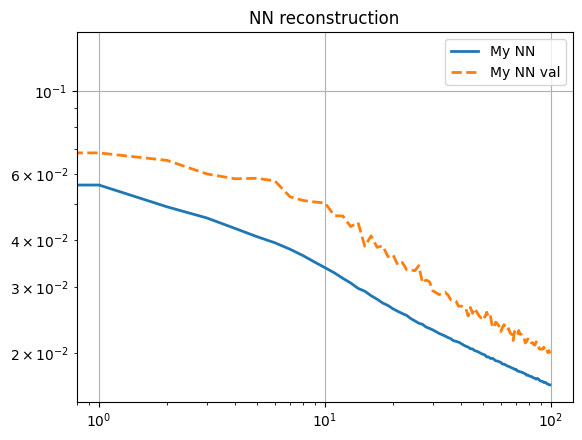

In [31]:
bc     = history.history['mean_absolute_error']
val_bc = history.history['val_mean_absolute_error']

plt.loglog(range(np.shape(bc)[0]),bc, linewidth=2,)
plt.loglog(range(np.shape(val_bc)[0]),val_bc,'--', linewidth=2,)
plt.title('NN reconstruction')
plt.grid(True)

plt.legend(('My NN','My NN val'))
plt.show()

In [32]:
rec_output = model.predict(input_test)

254/254 [==============================] - 1s 4ms/step


Text(0.5, 0, 'x [-]')

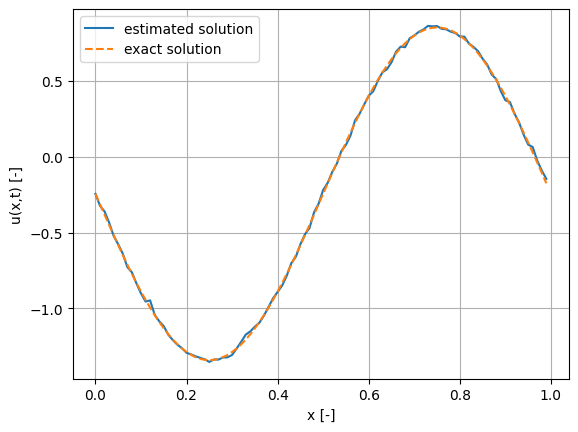

In [40]:
index = 1000
dx = 0.01
xx=np.arange(0,1,dx)

plt.figure()
plt.grid(True)
plt.plot(xx,rec_output[index,:], label='estimated solution')
plt.plot(xx,output_test[index,:], label='exact solution', linestyle='--')
plt.legend()
plt.ylabel('u(x,t) [-]')
plt.xlabel('x [-]')


In [34]:
save_NN = False
# save_NN = True
if save_NN:
    model.save('../data/Burgers/model_NN.h5')
    print('NN saved')